In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import dowhy
from dowhy import CausalModel

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def get_probs(df):
    df['phi'] = df['phi'].map({'tanh': 0, 'relu': 1}) # transfer phi to cat variable
#     p =  -1 + 1.0*df['phi'] + 0.5*df['g'] + 0.005*df['hidden']
    p =  -1 + 1.0*df['phi'] + 0.5*df['g'] + 0.001*df['hidden']
    probs_for_treatment = sigmoid(p)
    return probs_for_treatment
    

First we plot the ATE for random assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions


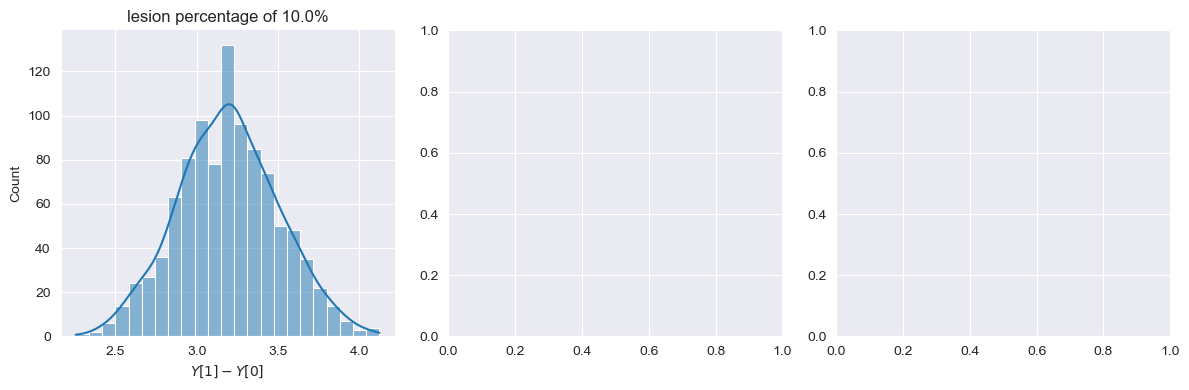

In [2]:
print('First we plot the ATE for random assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions')

fig,ax = plt.subplots(1,3,figsize=(12,4))

ate_random_treatment = [] 
for i,pr in enumerate([0.1]):
    data = pd.read_csv(f'data/results_{pr}_lesion.csv')
    x = [] 
    for _ in range(1000):
        t = np.random.randint(2,size=data.shape[0]).astype(bool)
        x.append(data[t].log_mse_lesion_activity.mean() - data[~t].log_mse_control.mean())
        
    ax[i].set_title(f'lesion percentage of {pr*100}%')
    sns.histplot(ax=ax[i],data=x, kde=True,label='Activity lesion')
    ax[i].set_xlabel(r'$Y[1] - Y[0]$')
    ate_random_treatment.append(x)
    
sns.despine()
plt.tight_layout()
plt.show()



Now we plot the ATE for targeted assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions


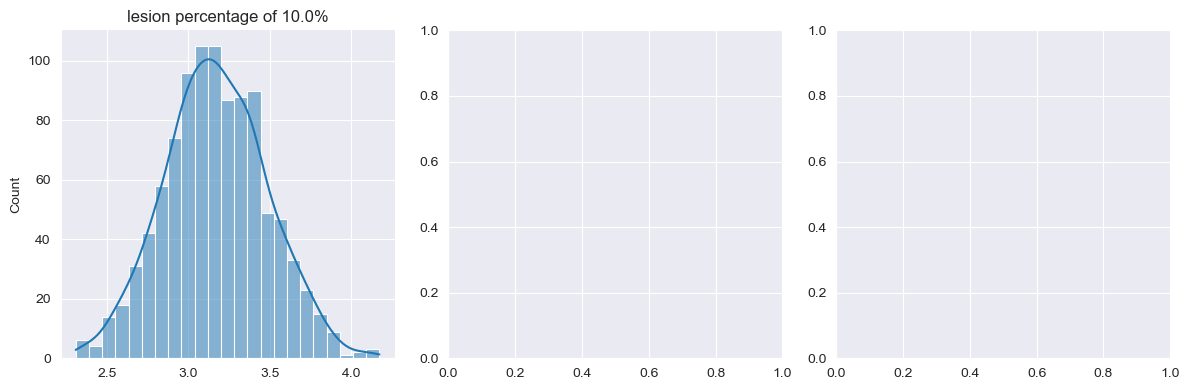

In [3]:
print('Now we plot the ATE for targeted assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions')

fig,ax = plt.subplots(1,3,figsize=(12,4))

ate_targted_treatment = []
for i,pr in enumerate([0.1]):
    df = pd.read_csv(f'data/results_{pr}_lesion.csv')
    
    probs_for_treatment = get_probs(df)
    
    x = [] 
    for _ in range(1000):
        treatment_assignment = np.array([np.random.choice(a=[0,1],p=[1-probs_for_treatment[ii],probs_for_treatment[ii]]) for ii in range(df.shape[0])])
        outcome_based_on_treatment = np.array([df.log_mse_control[ii] if treatment_assignment[ii]==0 else df.log_mse_lesion_activity[ii] for ii in range(df.shape[0])] )
        reduce_df = df[['hidden','g','phi']].copy()
        reduce_df['treatment'] = treatment_assignment.astype(int)
        reduce_df['outcome'] = outcome_based_on_treatment
        
        model = smf.ols('outcome ~ hidden + g + phi + treatment', data=reduce_df).fit()
        x.append(model.params['treatment'])
    
    ax[i].set_title(f'lesion percentage of {pr*100}%')
    sns.histplot(ax=ax[i],data=x,kde=True,label='Activity lesion')
    ate_targted_treatment.append(x)

sns.despine()
plt.tight_layout()
plt.show()
    

plot both the ATE of the random and targeted assigmnet of treatment togther


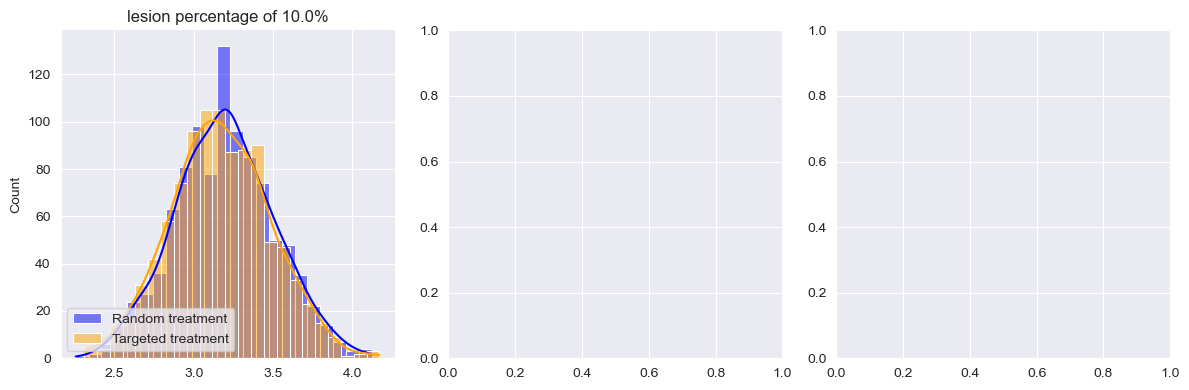

In [4]:
print('plot both the ATE of the random and targeted assigmnet of treatment togther')

fig,ax = plt.subplots(1,3,figsize=(12,4))

for i,pr in enumerate([0.1]):
    ax[i].set_title(f'lesion percentage of {pr*100}%')
    sns.histplot(ax=ax[i],data=ate_random_treatment[i], kde=True,label='Random treatment', color='blue')
    sns.histplot(ax=ax[i],data=ate_targted_treatment[i],kde=True,label='Targeted treatment', color='orange')
    ax[i].legend(loc='lower left')
sns.despine()
plt.tight_layout()
plt.show()

In [5]:

pr=0.1
df = pd.read_csv(f'data/results_{pr}_lesion.csv')

# df['phi'] = df['phi'].map({'tanh': 0, 'relu': 1}) # transfer phi to cat variable

# normalize hidden and g variable  
# columns_to_normalize = ['hidden', 'g']
# scaler = StandardScaler()
# df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# p =  -1 + 0.5*df['phi'] + 0.3*df['g'] + 0.001*df['hidden']
# p =  -1 + 1.0*df['phi'] + 0.5*df['g'] + 0.001*df['hidden']

         
# # Sigmoid function
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

probs_for_treatment = get_probs(df)

np.random.seed(42)

treatment_assignment = np.array([np.random.choice(a=[0,1],p=[1-probs_for_treatment[i],probs_for_treatment[i]]) for i in range(df.shape[0])])
outcome_based_on_treatment = np.array([df.log_mse_control[i] if treatment_assignment[i]==0 else df.log_mse_lesion_activity[i] for i in range(df.shape[0])] )
reduce_df = df[['hidden','g','phi']].copy()
reduce_df['treatment'] = treatment_assignment.astype(int)
reduce_df['outcome'] = outcome_based_on_treatment



Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[outcome|phi,g,hidden])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,phi,g,hidden,U) = P(outcome|treatment,phi,g,hidden)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
3.059552764256887


AttributeError: 'CausalEstimate' object has no attribute 'confidence_intervals'

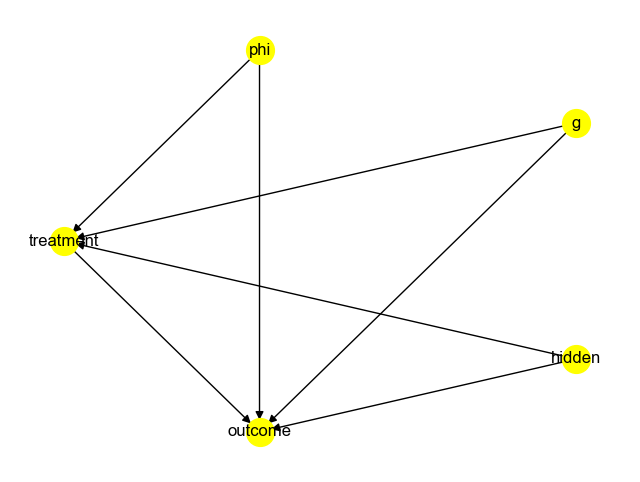

In [20]:

g = """ 

digraph{
treatment;
outcome;
hidden;
g;
phi;

treatment -> outcome;

hidden -> outcome;
g -> outcome;
phi -> outcome;

hidden -> treatment;
g -> treatment;
phi -> treatment;

}

"""


model = CausalModel(
    data=reduce_df,
    treatment='treatment',
    outcome='outcome',
    graph=g
)

model.view_model()

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

metode = 'backdoor.linear_regression' # 
deiserd_efffect = 'ate'
# 

estimate = model.estimate_effect(identified_estimand,
                                method_name=metode,
                                target_units=deiserd_efffect,
                                 test_significance=True,
                                 confidence_intervals = True
                                )

print(estimate.value)
print(estimate.confidence_intervals)

refute_placebo_treatment = model.refute_estimate(
    identified_estimand,  
    estimate,  
    method_name="placebo_treatment_refuter",  
    placebo_type="permute" , #  method_name="random_common_cause"
    show_progress_bar=True
)
# print(refute_placebo_treatment)

In [21]:
estimate.get_confidence_intervals()

array([[2.1309528 , 3.98815273]])

In [16]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Step 1: Estimate Propensity Scores using Logistic Regression
X = reduce_df[['hidden', 'g', 'phi']]
log_reg = LogisticRegression()
reduce_df['propensity_score'] = log_reg.fit(X, reduce_df['treatment']).predict_proba(X)[:, 1]

# Step 2: Calculate Inverse Probability Weights
reduce_df['weight'] = np.where(
    reduce_df['treatment'] == 1,
    1 / reduce_df['propensity_score'],
    1 / (1 - reduce_df['propensity_score'])
)

# Step 3: Estimate the ATE using IPW
treated_mse = np.average(
    reduce_df[reduce_df['treatment'] == 1]['outcome'],
    weights=reduce_df[reduce_df['treatment'] == 1]['weight']
)
untreated_mse = np.average(
    reduce_df[reduce_df['treatment'] == 0]['outcome'],
    weights=reduce_df[reduce_df['treatment'] == 0]['weight']
)

ATE_ipw = treated_mse - untreated_mse
print(f"ATE (IPW): {ATE_ipw}")


ATE (IPW): 3.0627397337049818


In [8]:
import statsmodels.api as sm

# Step 1: Prepare Data for Linear Regression
X_reg = sm.add_constant(reduce_df[['treatment', 'hidden', 'g', 'phi']])
y = reduce_df['outcome']

# Step 2: Fit Linear Regression Model
model_reg = sm.OLS(y, X_reg).fit()

# Step 3: Extract the ATE from the Treatment Coefficient
ATE_regression = model_reg.params['treatment']
print(f"ATE (Regression Adjustment): {ATE_regression}")
print(model_reg.summary())


ATE (Regression Adjustment): 3.059552764256888
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     10.82
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.15e-07
Time:                        21:46:36   Log-Likelihood:                -348.05
No. Observations:                 144   AIC:                             706.1
Df Residuals:                     139   BIC:                             721.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

In [9]:
# Step 1: Prepare the Design Matrix for Outcome Regression
X_reg = sm.add_constant(reduce_df[['hidden', 'g', 'phi']])  # Features for regression

# Step 2: Fit the Outcome Model Separately for Treated and Untreated Groups
model_reg_control = sm.OLS(reduce_df[reduce_df['treatment'] == 0]['outcome'], 
                           X_reg[reduce_df['treatment'] == 0]).fit()

model_reg_treated = sm.OLS(reduce_df[reduce_df['treatment'] == 1]['outcome'], 
                           X_reg[reduce_df['treatment'] == 1]).fit()

# Step 3: Predict Counterfactual Outcomes for All Units
reduce_df['y0_hat'] = model_reg_control.predict(X_reg)  # Outcome if untreated
reduce_df['y1_hat'] = model_reg_treated.predict(X_reg)  # Outcome if treated

# Step 4: Calculate the Doubly Robust Estimator
# For treated units: Use observed outcome, otherwise use predicted y0_hat
reduce_df['dr_outcome'] = np.where(
    reduce_df['treatment'] == 1,
    reduce_df['outcome'] - reduce_df['y1_hat'],  # Correct deviation if treated
    reduce_df['outcome'] - reduce_df['y0_hat']   # Correct deviation if untreated
)

# Apply the DR correction term
reduce_df['dr_term'] = (
    (reduce_df['treatment'] - reduce_df['propensity_score']) /
    (reduce_df['propensity_score'] * (1 - reduce_df['propensity_score']))
)

# Step 5: Compute the Final Doubly Robust ATE
ATE_doubly_robust = np.mean(
    reduce_df['dr_term'] * reduce_df['dr_outcome'] +
    reduce_df['y1_hat'] - reduce_df['y0_hat']
)

print(f"ATE (Doubly Robust): {ATE_doubly_robust}")


ATE (Doubly Robust): 3.092040046700279


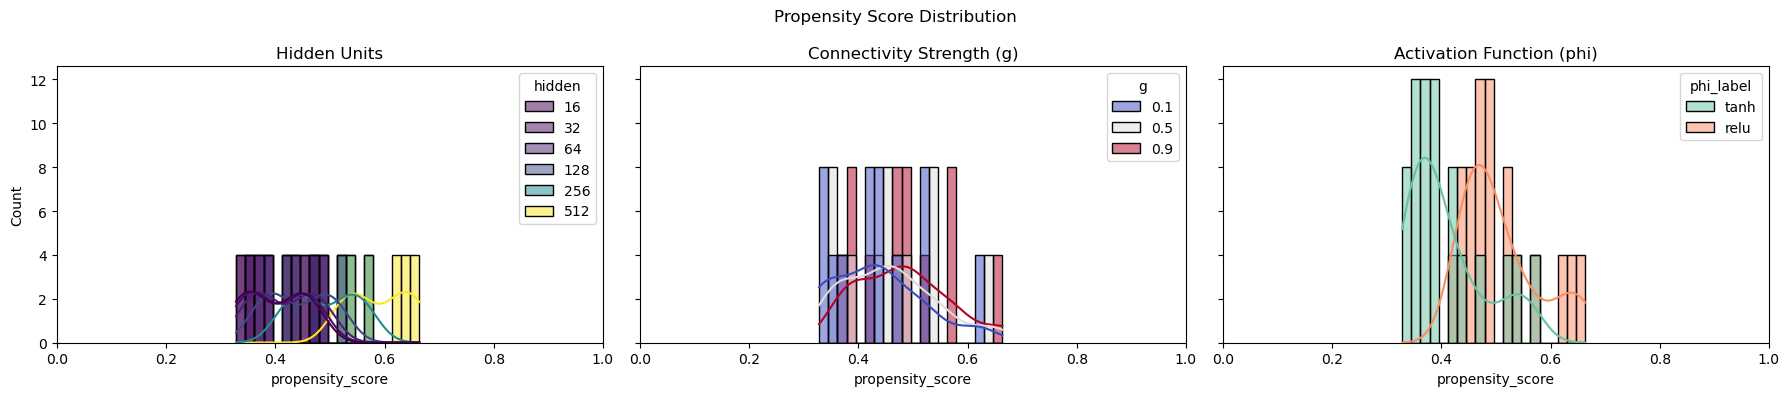

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map 'phi' values for plotting
reduce_df['phi_label'] = reduce_df['phi'].map({0: 'tanh', 1: 'relu'})

# Plot probability distribution for each hyperparameter category
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey='all')

# Plot for 'hidden' with a specific colormap
sns.histplot(
    reduce_df, x='propensity_score', hue='hidden', bins=20, ax=axes[0], kde=True, palette='viridis'
)
axes[0].set_title('Hidden Units')

# Plot for 'g' with a different colormap
sns.histplot(
    reduce_df, x='propensity_score', hue='g', bins=20, ax=axes[1], kde=True, palette='coolwarm'
)
axes[1].set_title('Connectivity Strength (g)')

# Plot for 'phi' with mapped labels and a third colormap
sns.histplot(
    reduce_df, x='propensity_score', hue='phi_label', bins=20, ax=axes[2], kde=True, palette='Set2'
)
axes[2].set_title('Activation Function (phi)')

for ax in axes:
    ax.set_xlim(left=0, right=1)

plt.suptitle('Propensity Score Distribution')

plt.tight_layout()
plt.show()


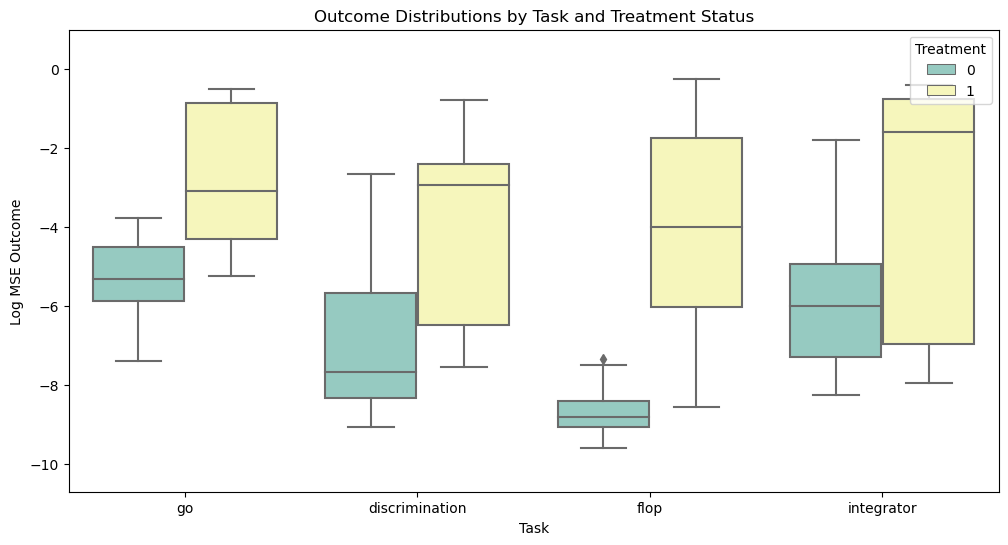

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add task column to reduce_df (assuming tasks are in original df)
reduce_df['task'] = df['task']  # Ensure 'task' exists in the original dataframe

# Create boxplots to compare outcomes by task and treatment status
plt.figure(figsize=(12, 6))
sns.boxplot(data=reduce_df, x='task', y='outcome', hue='treatment', palette='Set3')
plt.title('Outcome Distributions by Task and Treatment Status')
plt.xlabel('Task')
plt.ylabel('Log MSE Outcome')
plt.legend(title='Treatment', loc='upper right')
plt.ylim(top= 1)
plt.show()


In [12]:
reduce_df

,hidden,g,phi,treatment,outcome,propensity_score,weight,y0_hat,y1_hat,dr_outcome,dr_term
0,16,0.1,0,0,-5.288291,0.327919,1.487916,-5.837280,-2.761282,0.548989,-1.487916
1,16,0.1,0,1,-0.835032,0.327919,3.049534,-5.837280,-2.761282,1.926250,3.049534
2,16,0.1,0,1,-5.833067,0.327919,3.049534,-5.837280,-2.761282,-3.071785,3.049534
3,16,0.1,0,0,-2.902572,0.327919,1.487916,-5.837280,-2.761282,2.934708,-1.487916
4,16,0.1,1,0,-4.231009,0.423969,1.736019,-4.541045,-5.616530,0.310036,-1.736019
...,...,...,...,...,...,...,...,...,...,...,...
139,512,0.9,0,1,-0.702146,0.566721,1.764538,-8.857999,-1.379865,0.677720,1.764538
140,512,0.9,1,1,-4.316759,0.663649,1.506821,-7.561765,-4.235113,-0.081645,1.506821
141,512,0.9,1,0,-7.933305,0.663649,2.973082,-7.561765,-4.235113,-0.371540,-2.973082
142,512,0.9,1,1,-1.619143,0.663649,1.506821,-7.561765,-4.235113,2.615970,1.506821


In [ ]:
print("Estimating the effect of each task alone, i.e., stratification")

tasks = ['go', 'discrimination', 'flop', 'integrator']
probabilities = [0.1]

# Initialize dictionaries to hold results for each task
ate_random_treatment = {task: [] for task in tasks}
ate_targeted_treatment = {task: [] for task in tasks}

for task in tasks:
    print(f"\nEstimating treatment effect for task: {task}")
    
    for pr in probabilities:
        # Load and filter data for the current task
        data = pd.read_csv(f'data/results_{pr}_lesion.csv')
        data_task = data[data['task'] == task].reset_index()
        
        # Random treatment effect
        x_random = []
        for _ in range(1_000):
            t = np.random.randint(2, size=data_task.shape[0]).astype(bool)
            x_random.append(data_task[t].log_mse_lesion_activity.mean() - data_task[~t].log_mse_control.mean())
        ate_random_treatment[task].append(x_random)
        
        # Targeted treatment effect
        x_targeted = []
        data_task['phi'] = data_task['phi'].map({'tanh': 0, 'relu': 1})  # Map 'phi' to categorical
        p =  -1 + -2*data_task['phi'] + 0.5*data_task['g'] + 0.005*data_task['hidden']
        probs_for_treatment = sigmoid(p)
        
        for _ in range(1_000):
            treatment_assignment = np.array([np.random.choice(a=[0,1], p=[1 - probs_for_treatment[ii], probs_for_treatment[ii]]) for ii in range(data_task.shape[0])])
            outcome_based_on_treatment = np.array([data_task.log_mse_control[ii] if treatment_assignment[ii] == 0 else data_task.log_mse_lesion_activity[ii] for ii in range(data_task.shape[0])])
            
            reduce_df = data_task[['hidden', 'g', 'phi']].copy()
            reduce_df['treatment'] = treatment_assignment.astype(int)
            reduce_df['outcome'] = outcome_based_on_treatment
            
            model = smf.ols('outcome ~ hidden + g + phi + treatment', data=reduce_df).fit()
            x_targeted.append(model.params['treatment'])
        
        ate_targeted_treatment[task].append(x_targeted)


# Plotting
fig, axes = plt.subplots(len(tasks), 3, figsize=(12, 4 * len(tasks)), sharey=True)

for task_idx, task in enumerate(tasks):
    for i, pr in enumerate(probabilities):
        ax = axes[task_idx, i] if len(tasks) > 1 else axes[i]
        ax.set_title(f'{task.capitalize()} - Lesion Percentage: {pr * 100}%')
        sns.histplot(ax=ax, data=ate_random_treatment[task][i], kde=True, label='Random treatment')
        sns.histplot(ax=ax, data=ate_targeted_treatment[task][i], kde=True, label='Targeted treatment')
        
        ax.legend(loc='lower left')

sns.despine()
plt.tight_layout()
plt.show()



In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from dowhy import CausalModel


reduce_df['task'] = df['task']
# Assuming `reduce_df` has a `task` column to filter by task
tasks = reduce_df['task'].unique()
results = {}

# Loop over each task and calculate ATE using all methods
for task in tasks:
    # Filter the DataFrame for the current task
    task_df = reduce_df[reduce_df['task'] == task].copy()
    results[task] = {}

    # --- Method 1: Backdoor Adjustment with Linear Regression ---
    g = """ 
    digraph{
        treatment;
        outcome;
        hidden;
        g;
        phi;
        treatment -> outcome;
        hidden -> outcome;
        g -> outcome;
        phi -> outcome;
        hidden -> treatment;
        g -> treatment;
        phi -> treatment;
    }
    """

    model = CausalModel(
        data=task_df,
        treatment='treatment',
        outcome='outcome',
        graph=g
    )

    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                     method_name='backdoor.linear_regression',
                                     target_units='ate',
                                     test_significance=True,
                                     confidence_intervals=True)
    results[task]['ATE_Backdoor'] = estimate.value
    results[task]['CI_Backdoor'] = estimate.get_confidence_intervals()

    # --- Method 2: Inverse Probability Weighting (IPW) ---
    # Step 1: Estimate Propensity Scores using Logistic Regression
    X = task_df[['hidden', 'g', 'phi']]
    log_reg = LogisticRegression()
    task_df['propensity_score'] = log_reg.fit(X, task_df['treatment']).predict_proba(X)[:, 1]

    # Step 2: Calculate Inverse Probability Weights
    task_df['weight'] = np.where(
        task_df['treatment'] == 1,
        1 / task_df['propensity_score'],
        1 / (1 - task_df['propensity_score'])
    )

    # Step 3: Estimate the ATE using IPW
    treated_mse = np.average(
        task_df[task_df['treatment'] == 1]['outcome'],
        weights=task_df[task_df['treatment'] == 1]['weight']
    )
    untreated_mse = np.average(
        task_df[task_df['treatment'] == 0]['outcome'],
        weights=task_df[task_df['treatment'] == 0]['weight']
    )
    results[task]['ATE_IPW'] = treated_mse - untreated_mse

    # --- Method 3: Regression Adjustment ---
    X_reg = sm.add_constant(task_df[['treatment', 'hidden', 'g', 'phi']])
    y = task_df['outcome']
    model_reg = sm.OLS(y, X_reg).fit()
    results[task]['ATE_RegressionAdjustment'] = model_reg.params['treatment']

    # --- Method 4: Doubly Robust Estimator ---
    # Step 1: Prepare the Design Matrix for Outcome Regression
    X_reg = sm.add_constant(task_df[['hidden', 'g', 'phi']])

    # Step 2: Fit the Outcome Model Separately for Treated and Untreated Groups
    model_reg_control = sm.OLS(task_df[task_df['treatment'] == 0]['outcome'], 
                               X_reg[task_df['treatment'] == 0]).fit()
    model_reg_treated = sm.OLS(task_df[task_df['treatment'] == 1]['outcome'], 
                               X_reg[task_df['treatment'] == 1]).fit()

    # Step 3: Predict Counterfactual Outcomes for All Units
    task_df['y0_hat'] = model_reg_control.predict(X_reg)  # Outcome if untreated
    task_df['y1_hat'] = model_reg_treated.predict(X_reg)  # Outcome if treated

    # Step 4: Calculate the Doubly Robust Estimator
    task_df['dr_outcome'] = np.where(
        task_df['treatment'] == 1,
        task_df['outcome'] - task_df['y1_hat'],  # Correct deviation if treated
        task_df['outcome'] - task_df['y0_hat']   # Correct deviation if untreated
    )
    task_df['dr_term'] = (
        (task_df['treatment'] - task_df['propensity_score']) /
        (task_df['propensity_score'] * (1 - task_df['propensity_score']))
    )

    # Step 5: Compute the Final Doubly Robust ATE
    results[task]['ATE_DoublyRobust'] = np.mean(
        task_df['dr_term'] * task_df['dr_outcome'] +
        task_df['y1_hat'] - task_df['y0_hat']
    )

# Convert results dictionary to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T
print(results_df)


linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
                ATE_Backdoor   ATE_IPW  ATE_RegressionAdjustment  \
go                  2.332489  2.323183                  2.332489   
discrimination      2.011564  2.028942                  2.011564